# Book Recommendation Engine Project

## By Harshini Raju

## Submission for Myraa Technologies

I am an avid reader and enjoy quite a few genres of books. Most of my reading options come from the internet or from a friend and after a point the list gets repetitive. When given the task of building a Recommendation Engine I had to choose to make one based on Book Recommendations. For this System I have used the KNN models, popular EDA techniques to analyse the data we have in hand and VEctorises models to identify context and recommend similar books to the users.

#### Dataset: Book-Crossing: User review ratings Dataset from Kaggle
https://www.kaggle.com/ruchi798/bookcrossing-dataset

The dataset contains three parts- Book details, User Details and the books' rating details
On cleaning and preprocessing the datasets and combining the necessary information from these three into a single dataset we obtain viable information on the book titles, author, publishing, ratings and the ISBN of the book. Using this information we can develop a pretty detailed Book Recommendation Engine.

## Importing Necessary Modules

In [234]:
import pandas as pd
import pandas_profiling
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import requests
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from PIL import Image 
from io import BytesIO

#### Importing the csv files as pandas DataFrames

In [235]:
book_ratings = pd.read_csv("D:/Book reviews/BX-Book-Ratings.csv", sep=";", encoding='CP1252', escapechar='\\')
books = pd.read_csv("D:/Book reviews/BX_Books.csv", sep=";", encoding='CP1252', escapechar='\\')
users = pd.read_csv("D:/Book reviews/BX-Users.csv", sep=";", encoding='CP1252', escapechar='\\')

In [236]:
book_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149780 non-null  int64 
 1   ISBN         1149780 non-null  object
 2   Book-Rating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


In [237]:
books.head(5)

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton & Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [238]:
users.head(5)

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


## Pre-processing the data

In [300]:
#Dropping records includes NaN values
book_ratings.dropna(inplace=True)

In [301]:
book_ratings.isna().sum()

User-ID        0
ISBN           0
Book-Rating    0
dtype: int64

In [241]:
location = users.Location.str.split(', ', expand=True)
users['City'] = location[0].str.title()
users['State'] = location[1].str.title()
users['Country'] = location[2].str.title()

In [242]:
fix_users_age = users[users.Age > 0]
fix_users_age = users[users.Age < 100]
users['Age'].fillna(fix_users_age['Age'].mean())
users = users[users.Age < 100]
users = users[users.Age > 4]

In [243]:
users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 166841 entries, 1 to 278854
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   User-ID   166841 non-null  int64  
 1   Location  166841 non-null  object 
 2   Age       166841 non-null  float64
 3   City      166841 non-null  object 
 4   State     166840 non-null  object 
 5   Country   164860 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 8.9+ MB


In [244]:
users.head(5)

,User-ID,Location,Age,City,State,Country
1,2,"stockton, california, usa",18.0,Stockton,California,Usa
3,4,"porto, v.n.gaia, portugal",17.0,Porto,V.N.Gaia,Portugal
5,6,"santa monica, california, usa",61.0,Santa Monica,California,Usa
9,10,"albacete, wisconsin, spain",26.0,Albacete,Wisconsin,Spain
10,11,"melbourne, victoria, australia",14.0,Melbourne,Victoria,Australia


In [245]:
users.isna().sum()

User-ID        0
Location       0
Age            0
City           0
State          1
Country     1981
dtype: int64

In [246]:
users['Country'].describe()

count     164860
unique       544
top          Usa
freq       75889
Name: Country, dtype: object

In [247]:
books.isna().sum()

ISBN                   0
Book-Title             0
Book-Author            1
Year-Of-Publication    0
Publisher              2
Image-URL-S            0
Image-URL-M            0
Image-URL-L            0
dtype: int64

In [248]:
books.loc[books.Publisher.isnull(),:]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
128896,193169656X,Tyrant Moon,Elaine Corvidae,2002,NaN,http://images.amazon.com/images/P/193169656X.0...,http://images.amazon.com/images/P/193169656X.0...,http://images.amazon.com/images/P/193169656X.0...
129043,1931696993,Finders Keepers,Linnea Sinclair,2001,NaN,http://images.amazon.com/images/P/1931696993.0...,http://images.amazon.com/images/P/1931696993.0...,http://images.amazon.com/images/P/1931696993.0...


In [249]:
books.loc[books.ISBN=='193169656X','Publisher']='Mundania Press LLC'
books.loc[books.ISBN=='1931696993','Publisher']='Novelbooks Incorporated'

In [250]:
books.loc[books.Publisher.isnull(),:]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L


In [251]:
books.loc[books['Book-Author'].isnull(),:]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
187700,9627982032,The Credit Suisse Guide to Managing Your Perso...,NaN,1995,Edinburgh Financial Publishing,http://images.amazon.com/images/P/9627982032.0...,http://images.amazon.com/images/P/9627982032.0...,http://images.amazon.com/images/P/9627982032.0...


In [252]:
books.loc[books.ISBN=='9627982032','book_author']='Larissa Anne Downe'

In [253]:
book_ratingss = book_ratings.drop_duplicates()
book_ratings = book_ratings[book_ratings['Book-Rating'] > 0]
books = books[books['Year-Of-Publication'] > 0]
books = books[books['Year-Of-Publication'] < 2021]

### Merging the cleaned datasets into one base dataset

In [254]:
df = pd.merge(users, book_ratings, on='User-ID')
df = pd.merge(df, books, on='ISBN')
df.head(5)

,User-ID,Location,Age,City,State,Country,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,book_author
0,19,"weston, ,",14.0,Weston,",",None,0375759778,7,Prague : A Novel,ARTHUR PHILLIPS,2003,Random House Trade Paperbacks,http://images.amazon.com/images/P/0375759778.0...,http://images.amazon.com/images/P/0375759778.0...,http://images.amazon.com/images/P/0375759778.0...,NaN
1,8720,"anchorage, alaska, usa",31.0,Anchorage,Alaska,Usa,0375759778,3,Prague : A Novel,ARTHUR PHILLIPS,2003,Random House Trade Paperbacks,http://images.amazon.com/images/P/0375759778.0...,http://images.amazon.com/images/P/0375759778.0...,http://images.amazon.com/images/P/0375759778.0...,NaN
2,24525,"denver, colorado, usa",28.0,Denver,Colorado,Usa,0375759778,5,Prague : A Novel,ARTHUR PHILLIPS,2003,Random House Trade Paperbacks,http://images.amazon.com/images/P/0375759778.0...,http://images.amazon.com/images/P/0375759778.0...,http://images.amazon.com/images/P/0375759778.0...,NaN
3,38502,"new york, new york, usa",34.0,New York,New York,Usa,0375759778,8,Prague : A Novel,ARTHUR PHILLIPS,2003,Random House Trade Paperbacks,http://images.amazon.com/images/P/0375759778.0...,http://images.amazon.com/images/P/0375759778.0...,http://images.amazon.com/images/P/0375759778.0...,NaN
4,108789,"seattle, washington, usa",27.0,Seattle,Washington,Usa,0375759778,7,Prague : A Novel,ARTHUR PHILLIPS,2003,Random House Trade Paperbacks,http://images.amazon.com/images/P/0375759778.0...,http://images.amazon.com/images/P/0375759778.0...,http://images.amazon.com/images/P/0375759778.0...,NaN


### Testing out the images

In [255]:
def images(col,i):
    url = df[col][i]
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    return img

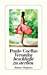

In [256]:
images('Image-URL-S',1100)

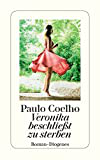

In [257]:
images('Image-URL-M',1100)

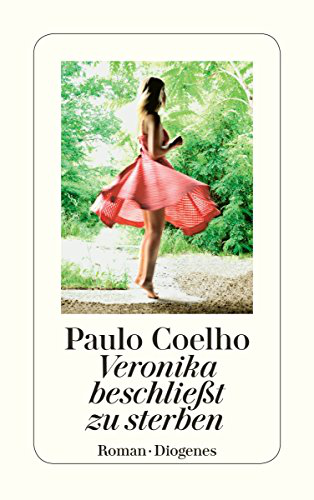

In [258]:
images('Image-URL-L',1100)

### Cleanign the merged dataset

In [259]:
df.drop_duplicates()

,User-ID,Location,Age,City,State,Country,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,book_author
0,19,"weston, ,",14.0,Weston,",",None,0375759778,7,Prague : A Novel,ARTHUR PHILLIPS,2003,Random House Trade Paperbacks,http://images.amazon.com/images/P/0375759778.0...,http://images.amazon.com/images/P/0375759778.0...,http://images.amazon.com/images/P/0375759778.0...,NaN
1,8720,"anchorage, alaska, usa",31.0,Anchorage,Alaska,Usa,0375759778,3,Prague : A Novel,ARTHUR PHILLIPS,2003,Random House Trade Paperbacks,http://images.amazon.com/images/P/0375759778.0...,http://images.amazon.com/images/P/0375759778.0...,http://images.amazon.com/images/P/0375759778.0...,NaN
2,24525,"denver, colorado, usa",28.0,Denver,Colorado,Usa,0375759778,5,Prague : A Novel,ARTHUR PHILLIPS,2003,Random House Trade Paperbacks,http://images.amazon.com/images/P/0375759778.0...,http://images.amazon.com/images/P/0375759778.0...,http://images.amazon.com/images/P/0375759778.0...,NaN
3,38502,"new york, new york, usa",34.0,New York,New York,Usa,0375759778,8,Prague : A Novel,ARTHUR PHILLIPS,2003,Random House Trade Paperbacks,http://images.amazon.com/images/P/0375759778.0...,http://images.amazon.com/images/P/0375759778.0...,http://images.amazon.com/images/P/0375759778.0...,NaN
4,108789,"seattle, washington, usa",27.0,Seattle,Washington,Usa,0375759778,7,Prague : A Novel,ARTHUR PHILLIPS,2003,Random House Trade Paperbacks,http://images.amazon.com/images/P/0375759778.0...,http://images.amazon.com/images/P/0375759778.0...,http://images.amazon.com/images/P/0375759778.0...,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263860,278851,"dallas, texas, usa",33.0,Dallas,Texas,Usa,0767907566,5,All Elevations Unknown: An Adventure in the He...,Sam Lightner,2001,Broadway Books,http://images.amazon.com/images/P/0767907566.0...,http://images.amazon.com/images/P/0767907566.0...,http://images.amazon.com/images/P/0767907566.0...,NaN
263861,278851,"dallas, texas, usa",33.0,Dallas,Texas,Usa,0789721260,5,WebClasses From Scratch,Jesse Liberty,1999,Que,http://images.amazon.com/images/P/0789721260.0...,http://images.amazon.com/images/P/0789721260.0...,http://images.amazon.com/images/P/0789721260.0...,NaN
263862,278851,"dallas, texas, usa",33.0,Dallas,Texas,Usa,0884159221,7,Why stop?: A guide to Texas historical roadsid...,Claude Dooley,1985,Lone Star Books,http://images.amazon.com/images/P/0884159221.0...,http://images.amazon.com/images/P/0884159221.0...,http://images.amazon.com/images/P/0884159221.0...,NaN
263863,278851,"dallas, texas, usa",33.0,Dallas,Texas,Usa,0912333022,7,The Are You Being Served? Stories: 'Camping In...,Jeremy Lloyd,1997,Kqed Books,http://images.amazon.com/images/P/0912333022.0...,http://images.amazon.com/images/P/0912333022.0...,http://images.amazon.com/images/P/0912333022.0...,NaN


In [260]:
df.drop(columns = ['Image-URL-S', 'Image-URL-M', 'Image-URL-L', 'Location', 'City', 'State', 'Country'])

,User-ID,Age,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,book_author
0,19,14.0,0375759778,7,Prague : A Novel,ARTHUR PHILLIPS,2003,Random House Trade Paperbacks,NaN
1,8720,31.0,0375759778,3,Prague : A Novel,ARTHUR PHILLIPS,2003,Random House Trade Paperbacks,NaN
2,24525,28.0,0375759778,5,Prague : A Novel,ARTHUR PHILLIPS,2003,Random House Trade Paperbacks,NaN
3,38502,34.0,0375759778,8,Prague : A Novel,ARTHUR PHILLIPS,2003,Random House Trade Paperbacks,NaN
4,108789,27.0,0375759778,7,Prague : A Novel,ARTHUR PHILLIPS,2003,Random House Trade Paperbacks,NaN
...,...,...,...,...,...,...,...,...,...
263860,278851,33.0,0767907566,5,All Elevations Unknown: An Adventure in the He...,Sam Lightner,2001,Broadway Books,NaN
263861,278851,33.0,0789721260,5,WebClasses From Scratch,Jesse Liberty,1999,Que,NaN
263862,278851,33.0,0884159221,7,Why stop?: A guide to Texas historical roadsid...,Claude Dooley,1985,Lone Star Books,NaN
263863,278851,33.0,0912333022,7,The Are You Being Served? Stories: 'Camping In...,Jeremy Lloyd,1997,Kqed Books,NaN


In [261]:
df= df.rename(columns={"User-ID": "User ID", "Book-Rating": "Book Rating", "Book-Author": "Book Author", "Book-Title": "Book Title","Year-Of-Publication": "Publication Year"})

## Analysis on the Data

In the analysis process, we are first identifying the average rating for each book that has been reviewed multiple times but various popular sources like Google and GoodReads. Doing this will help us in removing the duplicate from the dataset thus reducing redundancy when processing data and ensuring efficient use of time and space. 

In [302]:
avg_rating = df.groupby(['Book Title'])['Book Rating'].mean()
avg_rating = avg_rating.reset_index().rename(columns = {'Book Rating': 'Average Rating'})
print(avg_rating)

                                               Book Title  Average Rating
0        Ask Lily (Young Women of Faith: Lily Series, ...        8.000000
1                                            Dark Justice       10.000000
2        Earth Prayers From around the World: 365 Pray...        8.333333
3        Final Fantasy Anthology: Official Strategy Gu...       10.000000
4        Flight of Fancy: American Heiresses (Zebra Ba...        8.000000
...                                                   ...             ...
106953  Ã?Â?bernachten mit Stil. Die schÃ?Â¶nsten Coun...        8.000000
106954                     Ã?Â?rger mit Produkt X. Roman.        7.000000
106955                                Ã?Â?sterlich leben.        7.000000
106956                              Ã?Â?stlich der Berge.        8.000000
106957                                  Ã?Â?thique en toc        8.000000

[106958 rows x 2 columns]


In [263]:
books_with_reviews_and_users = df.merge(avg_rating, on = 'Book Title')
books_with_reviews_and_users = books_with_reviews_and_users[books_with_reviews_and_users['Book Title'] != 'Wild Animus']

books_with_reviews_and_users.head(5)

,User ID,Location,Age,City,State,Country,ISBN,Book Rating,Book Title,Book Author,Publication Year,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,book_author,Average Rating
0,19,"weston, ,",14.0,Weston,",",None,0375759778,7,Prague : A Novel,ARTHUR PHILLIPS,2003,Random House Trade Paperbacks,http://images.amazon.com/images/P/0375759778.0...,http://images.amazon.com/images/P/0375759778.0...,http://images.amazon.com/images/P/0375759778.0...,NaN,6.428571
1,8720,"anchorage, alaska, usa",31.0,Anchorage,Alaska,Usa,0375759778,3,Prague : A Novel,ARTHUR PHILLIPS,2003,Random House Trade Paperbacks,http://images.amazon.com/images/P/0375759778.0...,http://images.amazon.com/images/P/0375759778.0...,http://images.amazon.com/images/P/0375759778.0...,NaN,6.428571
2,24525,"denver, colorado, usa",28.0,Denver,Colorado,Usa,0375759778,5,Prague : A Novel,ARTHUR PHILLIPS,2003,Random House Trade Paperbacks,http://images.amazon.com/images/P/0375759778.0...,http://images.amazon.com/images/P/0375759778.0...,http://images.amazon.com/images/P/0375759778.0...,NaN,6.428571
3,38502,"new york, new york, usa",34.0,New York,New York,Usa,0375759778,8,Prague : A Novel,ARTHUR PHILLIPS,2003,Random House Trade Paperbacks,http://images.amazon.com/images/P/0375759778.0...,http://images.amazon.com/images/P/0375759778.0...,http://images.amazon.com/images/P/0375759778.0...,NaN,6.428571
4,108789,"seattle, washington, usa",27.0,Seattle,Washington,Usa,0375759778,7,Prague : A Novel,ARTHUR PHILLIPS,2003,Random House Trade Paperbacks,http://images.amazon.com/images/P/0375759778.0...,http://images.amazon.com/images/P/0375759778.0...,http://images.amazon.com/images/P/0375759778.0...,NaN,6.428571


In [268]:
books_with_reviews_and_users['Publication Year'].mean()

1995.734723398116

In [269]:
books_with_reviews_and_users['Age'].mean()

36.68389820534335

In [270]:
books_with_reviews_and_users['Book Rating'].mean()

7.745361494041224

Text(0.5, 1.0, 'Plot of Publication Year')

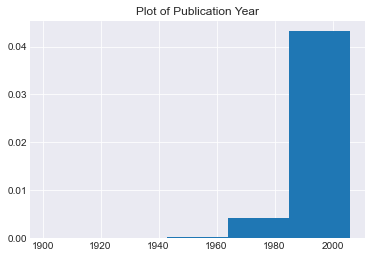

In [306]:
plt.hist(books_with_reviews_and_users['Publication Year'],density=True, bins=5)
plt.title('Plot of Publication Year')

Text(0.5, 1.0, 'Plot of Age')

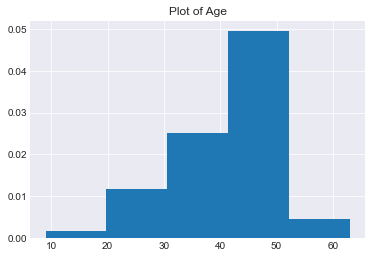

In [307]:
plt.hist(books_with_reviews_and_users['Age'],density=True, bins=5)
plt.title('Plot of Age')

Text(0.5, 1.0, 'Plot of Book Rating')

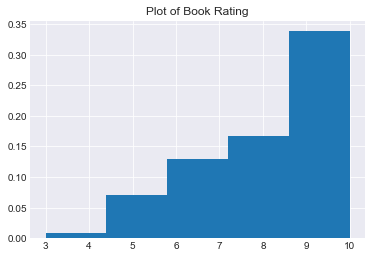

In [308]:
plt.hist(books_with_reviews_and_users['Book Rating'],density=True, bins=5)
plt.title('Plot of Book Rating')

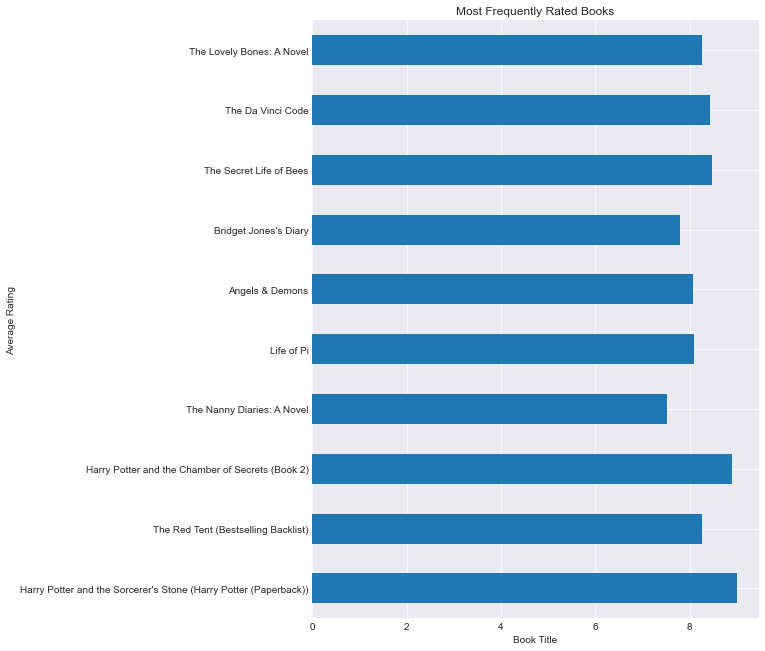

In [271]:
books_with_reviews_and_users['Frequency'] = books_with_reviews_and_users['Book Title'].map(books_with_reviews_and_users['Book Title'].value_counts())
books_by_rating_and_frequency = books_with_reviews_and_users[['Book Title', 'Average Rating', 'Frequency']].groupby('Book Title').mean().sort_values('Frequency', ascending=False).head(10)
plt.style.use('seaborn-darkgrid')
plt.figure()
final_rating_by_frequency = books_by_rating_and_frequency['Average Rating'].plot(kind='barh', figsize=(8,11))
final_rating_by_frequency.invert_yaxis()
plt.title("Most Frequently Rated Books")
plt.xlabel("Book Title")
plt.ylabel("Average Rating");

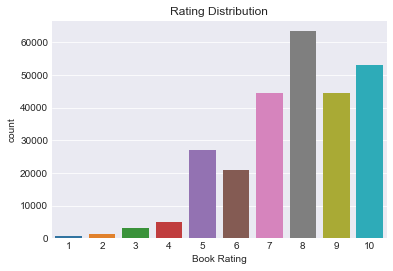

In [272]:
sns.countplot(x='Book Rating',data=books_with_reviews_and_users)
plt.title('Rating Distribution')
plt.show()

C:\Users\harsh\anaconda3\envs\ml\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


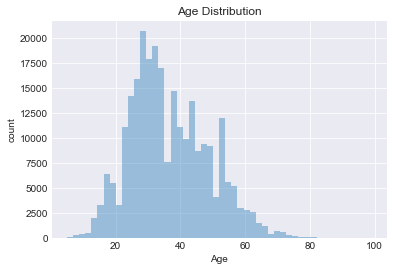

In [273]:
sns.distplot(books_with_reviews_and_users['Age'],kde=False)
plt.xlabel('Age')
plt.ylabel('count')
plt.title('Age Distribution')
plt.show()

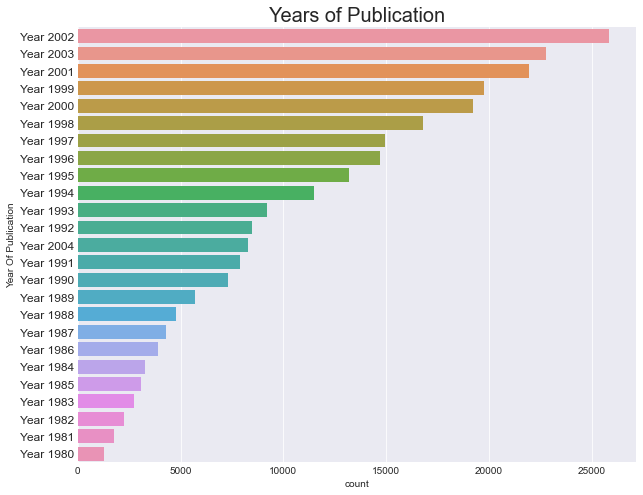

In [274]:
df_v=df[['Publication Year']].copy()
df_v['Publication Year'] = df_v['Publication Year'].astype(int).astype(str)
df_v=df_v['Publication Year'].value_counts().head(25).reset_index()
df_v.columns=['year','count']
df_v['year']='Year '+df_v['year']

plt.figure(figsize=(10,8))
sns.barplot(x='count',y='year',data=df_v)
plt.ylabel('Year Of Publication')
plt.yticks(size=12)
plt.title('Years of Publication',size=20)
plt.show()

## Building the Custom Recommendation System

In [275]:
counts1 = books_with_reviews_and_users['User ID'].value_counts()
books_with_reviews_and_users = books_with_reviews_and_users[books_with_reviews_and_users['User ID'].isin(counts1[counts1 >= 200].index)]
counts = books_with_reviews_and_users['Book Rating'].value_counts()
books_with_reviews_and_users = books_with_reviews_and_users[books_with_reviews_and_users['Book Rating'].isin(counts[counts >= 100].index)]

In [276]:
books_with_reviews_and_users.drop_duplicates(['User ID','Book Title'],inplace=True)

In [277]:
book_pivot=books_with_reviews_and_users.pivot_table(columns='User ID',index='Book Title',values='Book Rating')

In [278]:
book_pivot.fillna(0,inplace=True)

In [280]:
from scipy.sparse import csr_matrix
book_sparse=csr_matrix(book_pivot)

In [281]:
type(book_sparse)

scipy.sparse.csr.csr_matrix

### Using KNN for the Recommendation System

In [282]:
from sklearn.neighbors import NearestNeighbors
model=NearestNeighbors(metric = 'cosine', algorithm='brute')

In [283]:
model.fit(book_sparse)

NearestNeighbors(algorithm='brute', metric='cosine')

In [284]:
book_pivot.iloc[237,:].values.reshape(1,-1)

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 5., 0., 0.,
        0., 8., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 8., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]])

In [285]:
distances,suggestions=model.kneighbors(book_pivot.iloc[54,:].values.reshape(1,-1))

In [286]:
def reco(book_name):
    book_id=np.where(book_pivot.index==book_name)[0][0]
    distances,suggestions=model.kneighbors(book_pivot.iloc[book_id,:].values.reshape(1,-1))
    
    
    
    for i in range(len(suggestions)):
        if i==0:
            print("the suggestions for ",book_name,"are : ")
        if not i:
            print(book_pivot.index[suggestions[i]])

In [287]:
reco('Angels & Demons')

the suggestions for  Angels & Demons are : 
Index(['Angels & Demons', 'The Shipping News : A Novel', 'Tainted Blood',
       'The Unloved', 'The Longest Single Note'],
      dtype='object', name='Book Title')


### Using TFID Vectoriser and Count Vectoriser for the Recommendation system

In [288]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity

In [289]:
def content_based_recommender(book_title):
    
    book_title = str(book_title)
    if book_title in df['Book Title'].values:
        rating_counts = pd.DataFrame(df['Book Title'].value_counts())
        rare_books = rating_counts[rating_counts['Book Title'] <= 100].index
        common_books = df[~df['Book Title'].isin(rare_books)]
        
        if book_title in rare_books:
            
            random = pd.Series(common_books['Book Title'].unique()).sample(2).values
            print('There are no recommendations for this book')
            print('Try: \n')
            print('{}'.format(random[0]),'\n')
            print('{}'.format(random[1]),'\n')
        
        else:
            
            common_books = common_books.drop_duplicates(subset=['Book Title'])
            common_books.reset_index(inplace= True)
            common_books['index'] = [i for i in range(common_books.shape[0])]
            target_cols = ['Book Title','Book Author','Publisher']
            common_books['combined_features'] = [' '.join(common_books[target_cols].iloc[i,].values) for i in range(common_books[target_cols].shape[0])]
            cv = CountVectorizer()
            count_matrix = cv.fit_transform(common_books['combined_features'])
            cosine_sim = cosine_similarity(count_matrix)
            index = common_books[common_books['Book Title'] == book_title]['index'].values[0]
            sim_books = list(enumerate(cosine_sim[index]))
            sorted_sim_books = sorted(sim_books,key=lambda x:x[1],
                                      reverse=True)[1:6]
            
            books = []
            for i in range(len(sorted_sim_books)):
                books.append(common_books[common_books['index'] == sorted_sim_books[i][0]]['Book Title'].item())
            
            fig, axs = plt.subplots(1, 5,figsize=(18,5))
            fig.suptitle('You may also like these books', size = 22)
            for i in range(len(books)):
        
                url = common_books.loc[common_books['Book Title'] == books[i],'Image-URL-M'][:1].values[0]
                im = Image.open(requests.get(url, stream=True).raw)
                axs[i].imshow(im)
                axs[i].axis("off")
                axs[i].set_title('Rating: {}'.format(round(df[df['Book Title'] == books[i]]['Book Rating'].mean(),1)),
                             y=-0.18,
                                 color="red",
                                 fontsize=18)
                fig.show()
                     
    else:
        
        print('Cant find book in dataset, please check spelling')

## Finding the Output from the Model

**Procedure**
- The user will input the title of the book they liked and would like similar book recommendations.
- The model will search for the books that match the similarities of this book title input from the user.
- The book recommendations will be displayed as output

C:\Users\harsh\AppData\Local\Temp/ipykernel_9916/2750393048.py:48: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


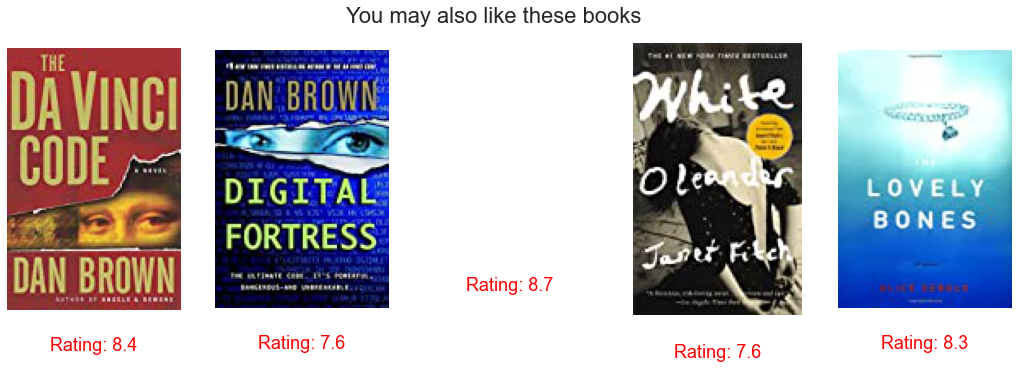

In [290]:
content_based_recommender('Angels & Demons')

C:\Users\harsh\AppData\Local\Temp/ipykernel_9916/2750393048.py:48: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


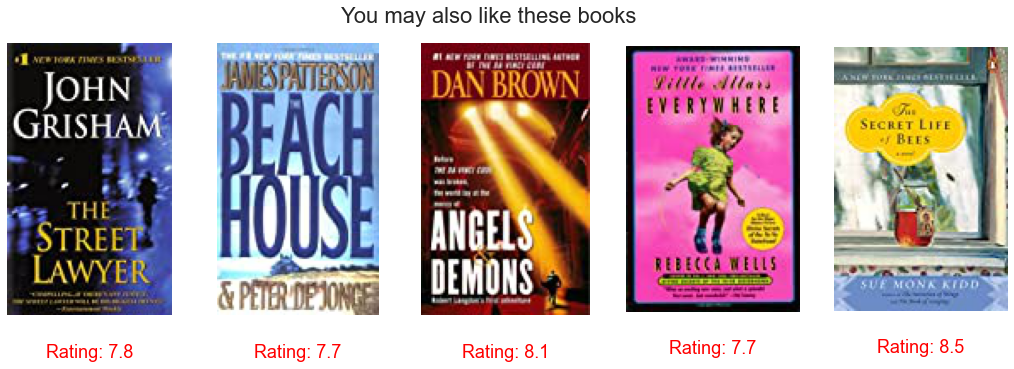

In [292]:
content_based_recommender('Fahrenheit 451')

C:\Users\harsh\AppData\Local\Temp/ipykernel_9916/2750393048.py:48: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


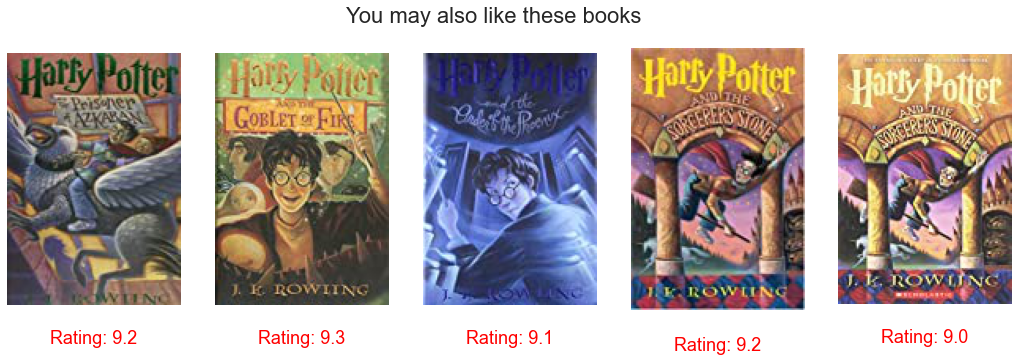

In [295]:
content_based_recommender('Harry Potter and the Chamber of Secrets (Book 2)')

C:\Users\harsh\AppData\Local\Temp/ipykernel_9916/2750393048.py:48: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


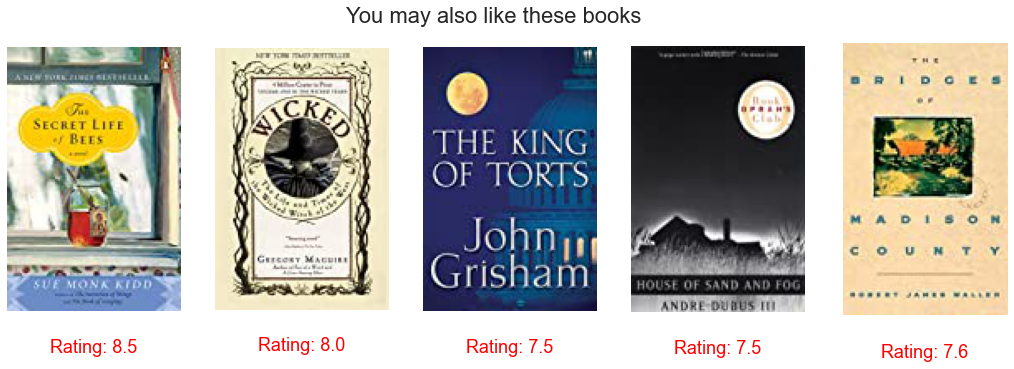

In [305]:
content_based_recommender('Life of Pi')

In [297]:
content_based_recommender('Das Testament')

There are no recommendations for this book
Try: 

Ender's Game (Ender Wiggins Saga (Paperback)) 

A Painted House 



In [299]:
content_based_recommender('The Jungle Books')

There are no recommendations for this book
Try: 

The Hobbit : The Enchanting Prelude to The Lord of the Rings 

The Red Tent (Bestselling Backlist) 



## Conclusion

The Vectoriser model is more accurate in the recommendations of similar books than the KNN model. The CountVectoriser and TFID Vectoriser model identifies the books similar to the book title input given by the user and responds back with a minimum of 5 recommendations that are in the same genre. The books that are not as popular in content in th3e dataset the model recommends slightly less similar books which still have pretty high accuracy for the model. 